In [ ]:
import sys
sys.path.append('../../')
import time
from jax_smi import initialise_tracking
initialise_tracking()
from tqdm import tqdm

: 

In [2]:
from dataclasses import dataclass, field, asdict
from typing import Tuple, Optional, Union
from EasyLM.models.gpt2.gpt2_model import GPT, GPTConfig, get_pretrained_params
from torch.utils.data import DataLoader

@dataclass(frozen=True)
class WandbConfig:
    """
    wandb logging configuration
    """
    entity: str = 'ars22'
    """username or team name where you're sending runs"""
    project: str = 'star_graph'
    """project name"""
    name: str = 'gpt2'
    """experiment name"""
    mode: str = 'online'
    """'offline', 'online', or 'disabled'"""
    notes: str = ''


@dataclass(frozen=True)
class CosineDecayScheduleConfig:
    init_value: float = 0.0
    peak_value: float = 2.5e-4
    warmup_steps: int = 2000
    decay_steps: int = 150000
    end_value: float = 1e-5

@dataclass(frozen=True)
class StaticLRConfig:
    init_value: float = 1e-4

@dataclass(frozen=False)
class TrainConfig:
    gpt2_model_type: str = 'gpt2' # gpt2 model type
    seed: int = 555
    out_dir: str = 'out'                        # output directory for checkpoints (can be gcs path)
    shuffle_buffer_size: int = 128
    eval_interval: int = 500
    eval_steps: int = 16        # evaluate for this number of steps (per-device)
    eval_only: bool = False     # if True, script exits right after the first eval
    keep_checkpoints: int = 3   # number of historical checkpoints to keep
    batch_size: int = 128        # per-device batch size
    train_steps: int = 30     # total number of training iterations
    weight_decay: float = 0.  # not applied to bias and embedding parameters
    grad_clip: float = 1.0      # gradient norm clipping magnitude
    gradient_accumulation_steps: int = 1    # used to simulate larger batch sizes
    betas: Tuple[float, float] = (0.9, 0.95) # adamw optimizer betas
    # learning_rate: CosineDecayScheduleConfig = field(default_factory=CosineDecayScheduleConfig)
    learning_rate: StaticLRConfig = field(default_factory=StaticLRConfig)
    wandb: WandbConfig = field(default_factory=WandbConfig) # wandb logging
    model: GPTConfig = field(default_factory=GPTConfig)     # gpt model config
    remat: bool = False    # set to True to rematerialize gradients during backward pass


def get_default_config() -> TrainConfig:
    return TrainConfig()

config = get_default_config()
config

/home/asetlur/anaconda3/envs/easylm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TrainConfig(gpt2_model_type='gpt2', seed=555, out_dir='out', shuffle_buffer_size=128, eval_interval=500, eval_steps=16, eval_only=False, keep_checkpoints=3, batch_size=128, train_steps=30, weight_decay=0.0, grad_clip=1.0, gradient_accumulation_steps=1, betas=(0.9, 0.95), learning_rate=StaticLRConfig(init_value=0.0005), wandb=WandbConfig(entity='ars22', project='star_graph', name='gpt2', mode='online', notes=''), model=GPTConfig(block_size=1024, vocab_size=50257, num_layers=12, num_heads=12, num_embeds=768, dropout_rate=0.1, use_bias=True, dtype=None), remat=False)

In [3]:
import jax
import jax.numpy as jnp
import flax
from flax.core import FrozenDict, frozen_dict
from flax.training import checkpoints
from flax.training.train_state import TrainState
from flax.jax_utils import replicate, unreplicate
import optax
from functools import partial

2024-05-14 04:10:44.073144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2024-05-14 04:10:44.073239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2024-05-14 04:10:44.073246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
from torch.utils.data import Dataset
import torch

def prefix_target_list(filename=None):
    """
    Load graphs and split them into prefix and target and return the list
    """
    data_list = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    for line in lines:
        prefix = line.strip().split('=')[0] + '='
        target = line.strip().split('=')[1]
        target_tokens = target.split(',')[1]
        import numpy as np
        from copy import deepcopy
        rev_target_tokens = deepcopy(np.array(target_tokens)[::-1])
        if np.random.uniform() > 1.:
            rev_target_tokens = rev_target_tokens[np.random.permutation(len(rev_target_tokens))]
            rev_target_tokens = rev_target_tokens.tolist()
        target = ",".join(rev_target_tokens) + ":" + ",".join(target_tokens)
        data_list.append((prefix, target))
    return data_list


class Graphs(Dataset):
    def __init__(self, tokenizer, n_samples, data_path):
        self.tokenizer = tokenizer
        self.n_samples = n_samples
        self.data_path = data_path
        self.eval_mode = False
        self.data_file = prefix_target_list(self.data_path)
        self.tokenized, self.num_prefix_tokens, self.num_target_tokens = self.tokenize(self.data_file[:n_samples])

    def __len__(self):
        return len(self.tokenized)

    def __getitem__(self, idx):
        if self.eval_mode:
            # In eval mode return the entire sequence
            return self.tokenized[idx].to(self.device)

        # Create inputs
        x = self.tokenized[idx].clone()
        y = torch.cat([-torch.ones((self.num_prefix_tokens - 1, )),
                       x[self.num_prefix_tokens:].clone()])
        return x[:-1], y.long()

    def tokenize(self, data_list):
        """
        Takes a list of prefix-target pairs, tokenizes and concatenates them
        """
        out = []
        prefix_len = len(self.tokenizer.encode(data_list[0][0]))
        target_len = len(self.tokenizer.encode(data_list[0][1]))
        same_len = True

        for prefix, target in data_list:
            prefix = torch.tensor(self.tokenizer.encode(prefix))
            target = torch.tensor(self.tokenizer.encode(target))
            if not (len(prefix) == prefix_len and len(target) == target_len):
                same_len = False
            seq = torch.concatenate([prefix, target], dim=-1).long()
            out.append(seq)

        # Check if all prefixes and all targets have the same length
        if not same_len:
            print('Not all prefixes or targets have the same length!!')
        else:
            print('Equal sequence lengths!')

        return out, prefix_len, target_len

    def eval(self):
        # Switch to "eval" mode when generating sequences without teacher-forcing
        self.eval_mode = True

    def train(self):
        # Switch back to "train" mode for teacher-forcing
        self.eval_mode = False

In [5]:
# LOAD TOKENIZER
from transformers import AutoTokenizer # type: ignore
tokenizer = AutoTokenizer.from_pretrained(config.gpt2_model_type)
tokenizer.pad_token_id = tokenizer.eos_token_id

# LOAD DATASET
data_path = 'deg_2_path_4_nodes_20'
train_path, test_path = data_path + '_train_200000.txt', data_path + '_test_20000.txt'
train_data = Graphs(tokenizer=tokenizer, n_samples=30000, data_path=train_path)
test_data = Graphs(tokenizer=tokenizer, n_samples=200, data_path=test_path)
train_data.train()

# sanity check
print(train_data[0], tokenizer.decode(train_data[0][0]), tokenizer.decode(train_data[0][1][-train_data.num_target_tokens:]))

# LOAD DATALOADER
train_loader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True, drop_last=True) 
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False, drop_last=False)


Equal sequence lengths!
Equal sequence lengths!
(tensor([2857,   11, 3132,   91,   22,   11, 2231,   91, 3132,   11, 2548,   91,
        2231,   11,   16,   91,   22,   11, 2857,   91,   16,   11, 1270,   14,
          22,   11, 1270,   28,   22,   11, 2231,   11,   16,   11]), tensor([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   22,   11, 2231,   11,   16,   11, 1270])) 47,31|7,45|31,38|45,1|7,47|1,30/7,30=7,45,1, 7,45,1,30


In [6]:
print("tokenizer vocab size: ", tokenizer.vocab_size, train_data.num_prefix_tokens, train_data.num_target_tokens)

tokenizer vocab size:  50257 28 7


In [7]:
def param_decay_mask(params: FrozenDict) -> FrozenDict:
    """ pytree mask for non-bias parameters """
    flat_params = flax.traverse_util.flatten_dict(params)
    flat_param_mask = {k: k[-1] not in ('bias', 'embedding', 'scale') for k in flat_params.keys()}
    param_mask = flax.traverse_util.unflatten_dict(flat_param_mask)
    return frozen_dict.freeze(param_mask)

def init_train_state(key, config: TrainConfig, learning_rate) -> TrainState:

    if config.remat:
        model = flax.linen.remat(GPT,
            static_argnums=(2,),
            policy=jax.checkpoint_policies.checkpoint_dots_with_no_batch_dims)(config.model)
    else:
        config.model, params = get_pretrained_params(config.gpt2_model_type)
        model = GPT(config.model)    
        model.init(key)

    optimizer = optax.chain(
        # Apply weight decay only to non-bias parameters
        optax.clip_by_global_norm(config.grad_clip),
        optax.adamw(learning_rate, *config.betas, weight_decay=config.weight_decay, mask=param_decay_mask(params)),
        optax.apply_every(config.gradient_accumulation_steps),
    )

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer)

    return train_state

def count_params(params: FrozenDict) -> int:
    p = jax.tree_util.tree_map(lambda a: a.size if isinstance(a, jnp.ndarray) else 0, params)
    return jax.tree_util.tree_reduce(lambda a, b: a + b, p)

In [8]:
# =====  init parameters ============
key = jax.random.PRNGKey(config.seed)
key, key_params, key_dropout, key_generation = jax.random.split(key, 4)
# make sure dropout keys are different for each device (local and global)
key_dropout = jax.random.fold_in(key_dropout, jax.process_index())
keys_dropout = jax.random.split(key_dropout, jax.local_device_count())
key_gen = jax.random.split(key_generation, jax.local_device_count())

In [9]:
learning_rate = config.learning_rate.init_value
train_state = init_train_state(key_params, config, learning_rate)
num_params = count_params(train_state.params)

loading weights from pretrained gpt: gpt2


In [10]:
print(f"Total parameters: {num_params:,}") # 774,030,080 for gpt2-large

Total parameters: 124,439,808


In [11]:
from flax.core import FrozenDict, freeze, unfreeze
from transformers import FlaxGPT2LMHeadModel
hf_model = FlaxGPT2LMHeadModel.from_pretrained(config.gpt2_model_type)
hf_params = hf_model.init_weights(key_params, (2, config.model.block_size))

In [12]:
# replicate model
train_state = replicate(train_state)
hf_params = replicate(hf_params)


In [13]:
def cross_entropy_loss_and_accuracy(logits, tokens, valid=None):
    if valid is None:
        valid = jnp.ones(tokens.shape[:2])
    valid = valid.astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    logits = logits.astype(jnp.float32)  # for numerical stability
    token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(logits, axis=-1),
            jnp.expand_dims(tokens, -1),
            axis=-1,
        ),
        -1,
    )
    token_log_prob = jnp.where(valid > 0.0, token_log_prob, jnp.array(0.0))
    loss = -(jnp.sum(token_log_prob) / jnp.sum(valid))
    # old: loss = -jnp.mean(jnp.sum(token_log_prob, axis=-1) / valid_text_length)
    # changed to match hf implementation
    correct = jnp.where(
        valid > 0.0,
        jnp.argmax(logits, axis=-1) == tokens,
        jnp.array(False)
    )
    accuracy = jnp.mean(jnp.sum(correct, axis=-1) / valid_text_length)
    return loss, accuracy


@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def train_step(state: TrainState, input_tokens: jnp.ndarray, target_tokens: jnp.ndarray, dropout_key):
    dropout_key = jax.random.fold_in(dropout_key, state.step)
    def loss_fn(params: FrozenDict) -> jnp.ndarray:
        logits = state.apply_fn(params, input_tokens, False, rngs={'dropout': dropout_key})
        
        logits = logits.astype(jnp.float32)  # for numerical stability
        token_log_prob = jnp.squeeze(
            jnp.take_along_axis(
                jax.nn.log_softmax(logits, axis=-1),
                jnp.expand_dims(target_tokens, -1),
                axis=-1,
            ),
            -1,
        )
        prob_hard_token = jnp.exp(token_log_prob[:, train_data.num_prefix_tokens+1]).mean()
        
        loss, acc = cross_entropy_loss_and_accuracy(
            logits, target_tokens, (target_tokens > 0).astype(jnp.int32))
        
        return loss, (prob_hard_token, acc)
    # per-device loss and grads
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (prob_hard_token, acc)), grads = grad_fn(state.params)
    # average gradients across devices
    prob_hard_token = jax.lax.pmean(prob_hard_token, axis_name="batch")
    grads = jax.lax.pmean(grads, axis_name="batch")
    loss = jax.lax.pmean(loss, axis_name="batch")
    acc = jax.lax.pmean(acc, axis_name="batch")
    new_state = state.apply_gradients(grads=grads)
    
    return loss, acc, prob_hard_token, new_state


from flax.traverse_util import flatten_dict, unflatten_dict

def convert_jax_params_to_hf(hf_params, jax_params) -> FrozenDict:
    hf_params = unfreeze(hf_params)
    
    for k in ['ln_f', 'wpe', 'wte']:
        hf_params['transformer'][k] = jax_params[k]
    for k in hf_params['transformer']['h'].keys():
        hf_params['transformer']['h'][k] = jax_params[k] 

    hf_params = flatten_dict(hf_params, sep='.')
    for k in hf_params.keys():
        if k.endswith('attn.c_attn.kernel'):
            hf_params[k] = hf_params[k].T
        elif k.endswith('attn.c_proj.kernel'):
            hf_params[k] = hf_params[k].T
        elif len(k.split('.')) > 3 and k.split('.')[3] == 'mlp' and k.endswith('kernel'):
            hf_params[k] = hf_params[k].T
    hf_params = unflatten_dict({k: v for k, v in hf_params.items()}, sep='.')
    return freeze(hf_params)


@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def eval_step(hf_params, state, input_tokens: jnp.ndarray, target_tokens: jnp.ndarray):
    hf_params = convert_jax_params_to_hf(hf_params, state.params['params'])
    output = hf_model.generate(
        input_tokens[:, :train_data.num_prefix_tokens],
        params=hf_params,
        max_new_tokens=train_data.num_target_tokens,
        min_length=train_data.num_target_tokens+train_data.num_prefix_tokens, 
        do_sample=False, 
        attention_mask=jnp.ones_like(input_tokens[:, :train_data.num_prefix_tokens]))
    acc = ((output[0][:, -train_data.num_target_tokens:] == target_tokens[:, -train_data.num_target_tokens:]).sum(1) == train_data.num_target_tokens).mean()
    acc = jax.lax.pmean(acc, axis_name="batch")
    return acc

max_new_tokens = train_data.num_target_tokens
num_beams=2
num_return_sequences=2
temperature=1.0

from flax.core import FrozenDict, freeze, unfreeze

@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0))
def generate_negative_data(hf_params, train_state, input_tokens, key):
    hf_params = convert_jax_params_to_hf(hf_params, train_state.params['params'])
    return hf_model.generate(
        input_tokens[:, :train_data.num_prefix_tokens],
        params=hf_params,
        max_new_tokens=max_new_tokens, 
        min_length=train_data.num_target_tokens+train_data.num_prefix_tokens,
        prng_key=key, 
        num_beams=num_beams, 
        num_return_sequences=num_return_sequences, 
        temperature=1.0,
        attention_mask=jnp.ones_like(input_tokens[:, :train_data.num_prefix_tokens]))



def evaluate(hf_params, state: TrainState, loader: DataLoader) -> jnp.ndarray:
    accs = []
    for batch in loader:
        input_tokens, target_tokens = batch
        input_tokens = jnp.array(input_tokens)
        target_tokens = jnp.array(target_tokens)
        input_tokens = input_tokens.reshape(jax.local_device_count(), -1, input_tokens.shape[-1])
        target_tokens = target_tokens.reshape(jax.local_device_count(), -1, target_tokens.shape[-1])
        acc = eval_step(hf_params, state, input_tokens, target_tokens)
        accs.append(acc)
    return jnp.mean(jnp.stack(accs))

In [14]:
class AverageMeter:
    def __init__(self):
        self.num = 0
        self.val = 0
        self.list = []

    def update(self, val, num):
        self.val += val * num
        self.num += num
        self.list.append(val)

    def reset_val(self):
        self.num = 0
        self.val = 0
        
    def get(self, percentage=False):
        if self.num > 0:
            val = self.val / self.num * 100 if percentage else self.val / self.num
            return val
        else:
            return 0

In [15]:
def get_log_likelihood(state, input_tokens, target_tokens, dropout_key):
    logits = state.apply_fn(state.params, input_tokens, False, rngs={'dropout': dropout_key})
    valid = (target_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    
    logits = logits.astype(jnp.float32)  # for numerical stability
    token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(logits, axis=-1),
            jnp.expand_dims(target_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    token_log_prob = jnp.where(valid > 0.0, token_log_prob, jnp.array(0.0))
    return token_log_prob 

def get_token_level_scores(original_dataset, generated_dataset):
    token_scores_arr = []
    for i in range(original_dataset.shape[0]):
        original_seq = original_dataset[i]
        generated_seq = generated_dataset[i]
        token_scores = (original_seq == generated_seq).float()
        incorrect = torch.where(token_scores==0)
        if len(incorrect[0]) > 0:
            token_scores[incorrect[0][0].item()] = -1. 
            token_scores[incorrect[0][0].item()+1:] = 0. 
        token_scores[:train_data.num_prefix_tokens] = 0.
        token_scores_arr.append(token_scores)
    return torch.stack(token_scores_arr, 0)

In [16]:
def dpo_loss(pos_logits, pos_tokens, neg_logits, neg_tokens):
    valid = (pos_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    pos_logits = pos_logits.astype(jnp.float32)  # for numerical stability
    pos_token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(pos_logits, axis=-1),
            jnp.expand_dims(pos_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    pos_token_log_prob = jnp.where(valid > 0.0, pos_token_log_prob, jnp.array(0.0))
    pos_token_log_prob = pos_token_log_prob.sum(axis=-1) 
    # / valid_text_length

    correct = jnp.where(
        (valid > 0.0),
        jnp.argmax(pos_logits, axis=-1) == pos_tokens,
        jnp.array(False)
    )
    accuracy = jnp.mean(jnp.sum(correct, axis=-1) / valid_text_length)
    

    valid = (neg_tokens > 0).astype(jnp.float32)
    valid_text_length = jnp.maximum(jnp.sum(valid, axis=-1), 1e-10)
    neg_logits = neg_logits.astype(jnp.float32)  # for numerical stability
    neg_token_log_prob = jnp.squeeze(
        jnp.take_along_axis(
            jax.nn.log_softmax(neg_logits, axis=-1),
            jnp.expand_dims(neg_tokens, -1),
            axis=-1,
        ),
        -1,
    )
    neg_token_log_prob = jnp.where(valid > 0.0, neg_token_log_prob, jnp.array(0.0))
    neg_token_log_prob = neg_token_log_prob.sum(axis=-1)
    # / valid_text_length

    loss =  (-jax.nn.log_sigmoid(0.01 * (pos_token_log_prob - neg_token_log_prob))).mean()
    # loss =  (pos_token_log_prob - neg_token_log_prob).mean()
    return loss, accuracy




@partial(jax.pmap, axis_name='batch', in_axes=(0, 0, 0, 0, 0, 0))
def train_step_onpolicy(state: TrainState, pos_input_tokens, pos_target_tokens, neg_input_tokens, neg_target_tokens, dropout_key) -> Tuple[jnp.ndarray, TrainState]:
    dropout_key = jax.random.fold_in(dropout_key, state.step)
    def loss_fn(params: FrozenDict) -> jnp.ndarray:
        pos_logits = state.apply_fn(params, pos_input_tokens, False, rngs={'dropout': dropout_key})
        neg_logits = state.apply_fn(params, neg_input_tokens, False, rngs={'dropout': dropout_key})
        loss, acc = dpo_loss(
            pos_logits, pos_target_tokens, neg_logits, neg_target_tokens)
        token_log_prob = jnp.squeeze(
            jnp.take_along_axis(
                jax.nn.log_softmax(pos_logits, axis=-1),
                jnp.expand_dims(pos_target_tokens, -1),
                axis=-1,
            ),
            -1,
        )
        prob_hard_token = jnp.exp(token_log_prob[:, train_data.num_prefix_tokens+1]).mean()
        return loss, (prob_hard_token, acc)    
        
    # per-device loss and grads
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (prob_hard_token, acc)), grads = grad_fn(state.params)
    # average gradients across devices
    grads = jax.lax.pmean(grads, axis_name="batch")
    loss = jax.lax.pmean(loss, axis_name="batch")
    acc = jax.lax.pmean(acc, axis_name="batch")
    prob_hard_token = jax.lax.pmean(prob_hard_token, axis_name="batch")
    new_state = state.apply_gradients(grads=grads)
    return loss, acc, prob_hard_token, new_state


In [17]:
import numpy as np
train_loss, train_acc, phard = AverageMeter(), AverageMeter(), AverageMeter() 
policy_train_acc, policy_test_acc = AverageMeter(), AverageMeter()
point = 0

In [18]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)


for ep in range(40):

    print(f"Epoch {ep+1}")

    loader = DataLoader(train_data, batch_size=256, shuffle=True, drop_last=True) 
    
    policy_train_acc.update(evaluate(hf_params, train_state, train_loader), 1)
    train_loss.reset_val()
    train_acc.reset_val()
    phard.reset_val()
        

    step = 0
    pbar = tqdm(loader, total=len(loader), desc='training on-policy')

    for input_tokens, target_tokens in pbar: 

        if ep < point:
            input_tokens = jnp.array(input_tokens)
            target_tokens = jnp.array(target_tokens)
            input_tokens = input_tokens.reshape(jax.device_count(), -1, input_tokens.shape[-1])
            target_tokens = target_tokens.reshape(jax.device_count(), -1, target_tokens.shape[-1])
            loss, acc, prob_hard_token, train_state = train_step(train_state, input_tokens, target_tokens, keys_dropout)
            if step % 5 == 0:
                train_loss.update(loss.mean(), input_tokens.shape[1] * jax.device_count())  
                train_acc.update(acc.mean(), input_tokens.shape[1] * jax.device_count())   
                phard.update(prob_hard_token.mean(), input_tokens.shape[1] * jax.device_count()) 
                policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)
        

        else:
            input_tokens = jnp.array(input_tokens)
            target_tokens = jnp.array(target_tokens)
            original = jnp.concatenate([input_tokens[:, :train_data.num_prefix_tokens], target_tokens[:, -train_data.num_target_tokens:]], axis=1)
            input_tokens = input_tokens.reshape(jax.device_count(), -1, input_tokens.shape[-1])
            generations = generate_negative_data(hf_params, train_state, input_tokens, key_gen)
            generations = generations[0].reshape(-1, generations[0].shape[-1]) 
            repeated_original = jnp.repeat(original[None, :, :], num_return_sequences, 0).transpose(1, 0, 2)
            original = repeated_original.reshape(-1, repeated_original.shape[-1])
            original = torch.tensor(np.array(original))
            generations = torch.tensor(np.array(generations))
            token_lvl_scores = get_token_level_scores(original , generations)
            pos_input_tokens = original.clone()
            pos_input_tokens = pos_input_tokens[:, :-1]
            pos_target_tokens = original.clone()
            pos_target_tokens[token_lvl_scores == 0] = -1   
            pos_target_tokens = pos_target_tokens[:, 1:]
            neg_input_tokens = generations.clone()
            neg_input_tokens = neg_input_tokens[:, :-1]
            neg_target_tokens = generations.clone()
            neg_target_tokens[token_lvl_scores == 0] = -1
            neg_target_tokens = neg_target_tokens[:, 1:]
            pos_input_tokens = jnp.array(pos_input_tokens)
            neg_input_tokens = jnp.array(neg_input_tokens)
            pos_target_tokens = jnp.array(pos_target_tokens)
            neg_target_tokens = jnp.array(neg_target_tokens)
            pos_input_tokens = pos_input_tokens.reshape(jax.device_count(), -1, pos_input_tokens.shape[-1])
            pos_target_tokens = pos_target_tokens.reshape(jax.device_count(), -1, pos_target_tokens.shape[-1])
            neg_input_tokens = neg_input_tokens.reshape(jax.device_count(), -1, neg_input_tokens.shape[-1])
            neg_target_tokens = neg_target_tokens.reshape(jax.device_count(), -1, neg_target_tokens.shape[-1])
            loss, acc, prob_hard_token, train_state = train_step_onpolicy(train_state, pos_input_tokens, pos_target_tokens, neg_input_tokens, neg_target_tokens, keys_dropout)
            if step % 5 == 0:
                train_loss.update(loss.mean(), pos_input_tokens.shape[1] * jax.device_count())  
                train_acc.update(acc.mean(), pos_input_tokens.shape[1] * jax.device_count())   
                phard.update(prob_hard_token.mean(), pos_input_tokens.shape[1] * jax.device_count()) 
                policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)
        if step % 5 == 0:
            pbar.set_description(f'train loss: {train_loss.get()} phard: {phard.get()} forcing train acc: {train_acc.get()} policy train acc: {policy_train_acc.list[-1]} policy test acc: {policy_test_acc.list[-1]}')
        step += 1

    # policy_train_acc.update(evaluate(hf_params, train_state, train_loader), 1)
    # policy_test_acc.update(evaluate(hf_params, train_state, test_loader), 1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 1


training on-policy:   0%|          | 0/117 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
train loss: 0.6939859390258789 phard: 0.0064900158904492855 forcing train acc: 0.6893208026885986 policy train acc: 0.0 policy test acc: 0.4939236044883728: 100%|██████████| 117/117 [03:13<00:00,  1.65s/it]


Epoch 2


train loss: 0.6932637691497803 phard: 0.03304413706064224 forcing train acc: 0.7991775274276733 policy train acc: 0.48888224363327026 policy test acc: 0.5134548544883728: 100%|██████████| 117/117 [00:22<00:00,  5.12it/s] 


Epoch 3


train loss: 0.693332850933075 phard: 0.036648258566856384 forcing train acc: 0.7990692853927612 policy train acc: 0.5125200748443604 policy test acc: 0.5572916269302368: 100%|██████████| 117/117 [00:23<00:00,  5.03it/s]


Epoch 4


train loss: 0.6932291984558105 phard: 0.028447896242141724 forcing train acc: 0.8292651176452637 policy train acc: 0.5240718722343445 policy test acc: 0.5060763955116272: 100%|██████████| 117/117 [00:22<00:00,  5.14it/s]


Epoch 5


train loss: 0.6931390762329102 phard: 0.05641920864582062 forcing train acc: 0.8429073691368103 policy train acc: 0.5289797186851501 policy test acc: 0.50390625: 100%|██████████| 117/117 [00:22<00:00,  5.14it/s]        


Epoch 6


train loss: 0.6931556463241577 phard: 0.1499839425086975 forcing train acc: 0.8477292060852051 policy train acc: 0.5468416213989258 policy test acc: 0.4717881977558136: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s] 


Epoch 7


train loss: 0.6925778388977051 phard: 0.32323339581489563 forcing train acc: 0.8614211082458496 policy train acc: 0.5553218722343445 policy test acc: 0.5091146230697632: 100%|██████████| 117/117 [00:22<00:00,  5.11it/s]


Epoch 8


train loss: 0.692255437374115 phard: 0.46409255266189575 forcing train acc: 0.8679718375205994 policy train acc: 0.5715478658676147 policy test acc: 0.5130208730697632: 100%|██████████| 117/117 [00:22<00:00,  5.10it/s] 


Epoch 9


train loss: 0.6913964152336121 phard: 0.5332906246185303 forcing train acc: 0.8782808184623718 policy train acc: 0.5945847034454346 policy test acc: 0.5095486044883728: 100%|██████████| 117/117 [00:22<00:00,  5.14it/s]


Epoch 10


train loss: 0.6896997690200806 phard: 0.5554850101470947 forcing train acc: 0.8845722079277039 policy train acc: 0.6073384284973145 policy test acc: 0.4900173544883728: 100%|██████████| 117/117 [00:22<00:00,  5.14it/s]


Epoch 11


train loss: 0.6875797510147095 phard: 0.582211971282959 forcing train acc: 0.8935540914535522 policy train acc: 0.6341813802719116 policy test acc: 0.5269097089767456: 100%|██████████| 117/117 [00:23<00:00,  5.08it/s] 


Epoch 12


train loss: 0.6841973066329956 phard: 0.6050605177879333 forcing train acc: 0.9001760482788086 policy train acc: 0.658052921295166 policy test acc: 0.5611978769302368: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s]


Epoch 13


train loss: 0.6797356605529785 phard: 0.6320791244506836 forcing train acc: 0.9074613451957703 policy train acc: 0.698684573173523 policy test acc: 0.4665798544883728: 100%|██████████| 117/117 [00:22<00:00,  5.17it/s]


Epoch 14


train loss: 0.6735255718231201 phard: 0.653765082359314 forcing train acc: 0.9137029647827148 policy train acc: 0.721788227558136 policy test acc: 0.5164930820465088: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s] 


Epoch 15


train loss: 0.6635947227478027 phard: 0.6754665374755859 forcing train acc: 0.9205791354179382 policy train acc: 0.753939688205719 policy test acc: 0.5047743320465088: 100%|██████████| 117/117 [00:22<00:00,  5.10it/s]


Epoch 16


train loss: 0.6489874124526978 phard: 0.7180593013763428 forcing train acc: 0.9301828145980835 policy train acc: 0.7844551801681519 policy test acc: 0.5230034589767456: 100%|██████████| 117/117 [00:22<00:00,  5.16it/s]


Epoch 17


train loss: 0.63194739818573 phard: 0.7425806522369385 forcing train acc: 0.9379277229309082 policy train acc: 0.8339677453041077 policy test acc: 0.5052083730697632: 100%|██████████| 117/117 [00:22<00:00,  5.17it/s]  


Epoch 18


train loss: 0.6141625642776489 phard: 0.7716781497001648 forcing train acc: 0.9475709795951843 policy train acc: 0.8582065105438232 policy test acc: 0.515625: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s]          


Epoch 19


train loss: 0.6104575395584106 phard: 0.7888621091842651 forcing train acc: 0.9556365013122559 policy train acc: 0.8982038497924805 policy test acc: 0.4856770932674408: 100%|██████████| 117/117 [00:22<00:00,  5.12it/s]


Epoch 20


train loss: 0.6251618266105652 phard: 0.7944270372390747 forcing train acc: 0.9627699851989746 policy train acc: 0.9165999293327332 policy test acc: 0.4852430820465088: 100%|██████████| 117/117 [00:22<00:00,  5.16it/s]


Epoch 21


train loss: 0.6293387413024902 phard: 0.7933766841888428 forcing train acc: 0.9673378467559814 policy train acc: 0.9368323087692261 policy test acc: 0.5069444179534912: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s]


Epoch 22


train loss: 0.6362889409065247 phard: 0.7974197268486023 forcing train acc: 0.971127986907959 policy train acc: 0.9558627605438232 policy test acc: 0.5455728769302368: 100%|██████████| 117/117 [00:22<00:00,  5.16it/s] 


Epoch 23


train loss: 0.6384758949279785 phard: 0.8041901588439941 forcing train acc: 0.9760260581970215 policy train acc: 0.9640759229660034 policy test acc: 0.5494791865348816: 100%|██████████| 117/117 [00:22<00:00,  5.11it/s]


Epoch 24


train loss: 0.6420443058013916 phard: 0.8040651679039001 forcing train acc: 0.978640079498291 policy train acc: 0.9697182774543762 policy test acc: 0.5455729365348816: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s] 


Epoch 25


train loss: 0.64043128490448 phard: 0.8156983852386475 forcing train acc: 0.980755090713501 policy train acc: 0.9755609631538391 policy test acc: 0.5086805820465088: 100%|██████████| 117/117 [00:22<00:00,  5.13it/s]   


Epoch 26


train loss: 0.6399105787277222 phard: 0.8078770637512207 forcing train acc: 0.982444167137146 policy train acc: 0.9777978658676147 policy test acc: 0.5121527910232544: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s] 


Epoch 27


train loss: 0.6385117769241333 phard: 0.8097565174102783 forcing train acc: 0.9842712879180908 policy train acc: 0.9802684783935547 policy test acc: 0.5425347089767456: 100%|██████████| 117/117 [00:22<00:00,  5.14it/s]


Epoch 28


train loss: 0.6460260152816772 phard: 0.8071675300598145 forcing train acc: 0.9854061007499695 policy train acc: 0.9843416810035706 policy test acc: 0.49609375: 100%|██████████| 117/117 [00:22<00:00,  5.16it/s]        


Epoch 29


train loss: 0.6500288844108582 phard: 0.7986708879470825 forcing train acc: 0.9859980940818787 policy train acc: 0.9859775900840759 policy test acc: 0.5021701455116272: 100%|██████████| 117/117 [00:22<00:00,  5.17it/s]


Epoch 30


train loss: 0.6504026055335999 phard: 0.8116080164909363 forcing train acc: 0.9868022203445435 policy train acc: 0.9868790507316589 policy test acc: 0.515625: 100%|██████████| 117/117 [00:22<00:00,  5.17it/s]          


Epoch 31


train loss: 0.6494237184524536 phard: 0.809444785118103 forcing train acc: 0.9866883754730225 policy train acc: 0.9881811141967773 policy test acc: 0.464409738779068: 100%|██████████| 117/117 [00:22<00:00,  5.12it/s]  


Epoch 32


train loss: 0.647352397441864 phard: 0.8204209804534912 forcing train acc: 0.987511396408081 policy train acc: 0.9887487292289734 policy test acc: 0.4852430522441864: 100%|██████████| 117/117 [00:22<00:00,  5.18it/s]  


Epoch 33


train loss: 0.6504188776016235 phard: 0.8164563179016113 forcing train acc: 0.9878178834915161 policy train acc: 0.9889490604400635 policy test acc: 0.4913194477558136: 100%|██████████| 117/117 [00:22<00:00,  5.17it/s]


Epoch 34


train loss: 0.6494545936584473 phard: 0.81486576795578 forcing train acc: 0.9882543087005615 policy train acc: 0.9887487292289734 policy test acc: 0.5416666865348816: 100%|██████████| 117/117 [00:22<00:00,  5.18it/s]  


Epoch 35


train loss: 0.6444227695465088 phard: 0.8182520270347595 forcing train acc: 0.9903124570846558 policy train acc: 0.9898504614830017 policy test acc: 0.4635416865348816: 100%|██████████| 117/117 [00:22<00:00,  5.18it/s]


Epoch 36


train loss: 0.6510202288627625 phard: 0.8152536749839783 forcing train acc: 0.9893617630004883 policy train acc: 0.9917535185813904 policy test acc: 0.4891493320465088: 100%|██████████| 117/117 [00:22<00:00,  5.16it/s]


Epoch 37


train loss: 0.6544226408004761 phard: 0.827040433883667 forcing train acc: 0.9900906085968018 policy train acc: 0.9902511239051819 policy test acc: 0.4835069477558136: 100%|██████████| 117/117 [00:22<00:00,  5.18it/s] 


Epoch 38


train loss: 0.651282012462616 phard: 0.8340356349945068 forcing train acc: 0.989688515663147 policy train acc: 0.9927217364311218 policy test acc: 0.4626736044883728: 100%|██████████| 117/117 [00:22<00:00,  5.18it/s]  


Epoch 39


train loss: 0.6515796780586243 phard: 0.8364819884300232 forcing train acc: 0.9911412000656128 policy train acc: 0.9920206069946289 policy test acc: 0.4639756977558136: 100%|██████████| 117/117 [00:22<00:00,  5.15it/s]


Epoch 40


train loss: 0.6446786522865295 phard: 0.8371303081512451 forcing train acc: 0.9909251928329468 policy train acc: 0.993990421295166 policy test acc: 0.5464409589767456: 100%|██████████| 117/117 [00:22<00:00,  5.10it/s]


In [19]:
# evaluate(hf_params, train_state, train_loader)
import pickle
a  = {
    'train_loss': train_loss.list,
    'train_acc': train_acc.list,
    'phard': phard.list,
    'policy_train_acc': policy_train_acc.list,
    'policy_test_acc': policy_test_acc.list 
} 
with open(f'sft_changeat_{point}_run.pkl', 'wb') as f:
    pickle.dump(a, f)

In [20]:
len(pickle.load(open(f'sft_changeat_{point}_run.pkl', 'rb'))['phard'])

960

In [21]:
# generate_negazative_data(hf_params, train_state, input_tokens, key_gen)[0].shape

In [22]:
# j = 31
# pos_input_tokens[j][j], pos_target_tokens[j][j], neg_input_tokens[j][j], neg_target_tokens[j][j]

In [23]:
len(policy_test_acc.list)

960

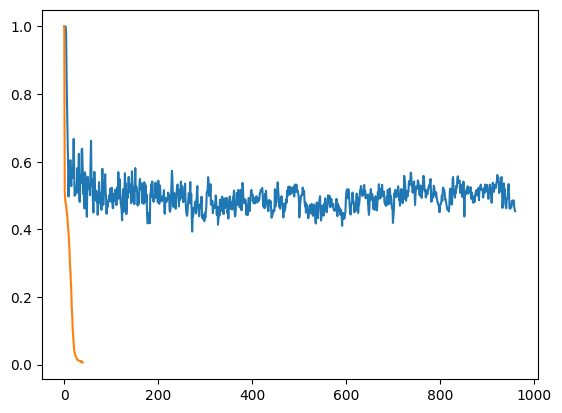

In [24]:
import matplotlib.pyplot as plt
plt.plot(1.0- np.array(policy_test_acc.list))
plt.plot(1.0- np.array(policy_train_acc.list))


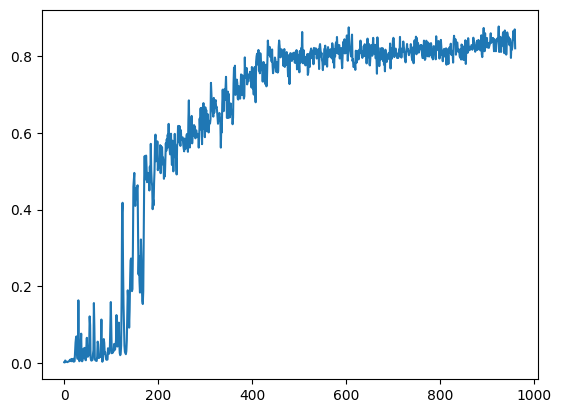

In [25]:
import matplotlib.pyplot as plt
plt.plot(phard.list)


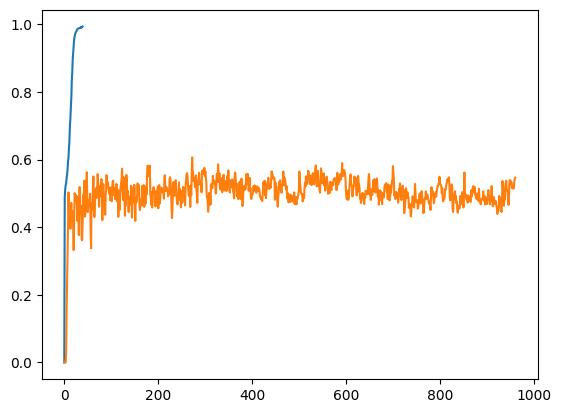

In [26]:
plt.plot(policy_train_acc.list)
plt.plot(policy_test_acc.list)

In [27]:
[round(1.0-x, 3) for x in np.array(pickle.load(open(f'sft_changeat_2_run.pkl', 'rb'))['policy_test_acc']).tolist()][:20]

[0.891,
 0.491,
 0.456,
 0.507,
 0.505,
 0.526,
 0.529,
 0.489,
 0.476,
 0.438,
 0.51,
 0.523,
 0.486,
 0.532,
 0.55,
 0.539,
 0.523,
 0.526,
 0.583,
 0.509]